In [2]:
import random
import math
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import numpy as np
from scipy.stats import poisson
from scipy.stats import norm
from statistics import median

In [3]:
def plot_func(func, x=np.linspace(0,5,3001), logscale=False, ylim=[], xlabel='', ylabel=''):
    y = np.vectorize(func)(x)
    plt.figure(figsize=(5,5))
    axes_internal = plt.gca()
    if logscale: axes_internal.set_yscale('log')
    if len(ylim) == 2: axes_internal.set_ylim(ylim)
    if xlabel: axes_internal.set_xlabel(xlabel)
    if ylabel: axes_internal.set_ylabel(ylabel)
    plt.title(func.__name__)
    plt.plot(x,y)
    plt.show()

In [4]:
# Useful functions

def factorial(x):
    if x == 0:
        return 1
    elif x > 0:
        for i in range(1,int(x)):
            x = x * i
        return x
    
# generate n, m based on inverse CDF of poisson distribution
# CDF gives you the p-value (CL) for a given value of the variable
# inverse of CDF gives you a value of the variable based on the p-value (0<p<1)
# This is why we use random.uniform(0,1) for the p-value
# nexpec, mexpec are the expected values of the poisson 
# (the expected rate where the variable is a function of time, as is common for poisson)

# see https://en.wikipedia.org/wiki/Poisson_distribution             for general poisson info
# see https://en.wikipedia.org/wiki/Cumulative_distribution_function for the CDF
# see https://en.wikipedia.org/wiki/Inverse_transform_sampling       for the method
# see https://www.kite.com/python/docs/scipy.stats.poisson           for documentation

def generate_nm(nexpec,mexpec,numev):
    ngen = [poisson.ppf(random.uniform(0,1),nexpec) for i in range(0,numev)]
    mgen = [poisson.ppf(random.uniform(0,1),mexpec) for i in range(0,numev)]
    return [ngen, mgen]


In [5]:
# Maximum Likelihood estimators for single bin
# tau, mu, s are input parameters and not included here
def mu_max(n,m,s,b,tau,mu): # for maximizing functions of 2 vars, b and mu in denominator of lambda (profile likelihood ratio)
    return (n - m/tau)/s
def b_max(n,m,s,b,tau,mu): #for maximizing fucntions of 2 vars, b and mu in denominator of lambda (profile likelihood ratio)
    return m/tau
def b_max1(n,m,s,b,tau,mu): #maximize fxn of 1 var, b, in numerator of lambda--NOTE THAT IT IS A FXN OF mu
    return (n+m-(1+tau)*mu*s)/(2*(1+tau)) + ( ((n+m-(1+tau)*mu*s)**2+4*(1+tau)*m*mu*s) * 0.25/(1+tau)**2 )**0.5


In [6]:
def likelihood(n,m,s,b,tau,mu): # s and tau are the only constants 
    return (mu*s+b)**n / (factorial(n)) * math.exp(-(mu*s+b)) * (tau*b)**m / factorial(m) * math.exp(-tau*b)

def PLR(n,m,s,b,tau,mu): #profile likelihood ratio
    return likelihood(n,m,s,b_max1(n,m,s,b,tau,mu),tau,mu)/(likelihood(n,m,s,b_max(n,m,s,b,tau,mu),tau,mu_max(n,m,s,b,tau,mu)))

# def PLRbar(n,m,s,b,tau,mu):
    

In [56]:
def q0(n,m,s,b,tau):
    # mu = 0
    if mu_max(n,m,s,b,tau,0) > 0:
        return -2*math.log(PLR(n,m,s,b,tau,0))
    else:
        return 0
    
def q_mu(n,m,s,b,tau,mu,mup):
    if mu_max(n,m,s,b,tau,mup) <= mu:
        return -2*math.log(PLR(n,m,s,b,tau,mu))
    else:
        return 0


def q_mubar(n,m,s,b,tau,mu,mup):
    mu_maxval = mu_max(n,m,s,b,tau,mup)
    if mu_maxval < 0:
        return -2*math.log(likelihood(n,m,s,b_max1(n,m,s,b,tau,mu),tau,mu)/(likelihood(n,m,s,b_max1(n,m,s,b,tau,0),tau,0)))
    elif 0 <= mu_maxval <= mu:
        return -2*math.log(PLR(n,m,s,b,tau,mu))
    else:
        return 0

In [8]:
# Expected # of events
def En(s,b,mu): # in signal region
    return mu*s+b
def Em(b,tau): # in control region
    return tau*b
#print(f"En: {En} Em: {Em}")

In [81]:
def sigmaq0(s,b,tau,mup):
    return math.sqrt(mup**2/q0(En(s,b,mup),Em(b,tau),s,b,tau))


def PDFq0(s,b,tau,mup,q0d):
#    return np.exp(-q0*0.5)*(2*math.sqrt(2*math.pi*q0))**-1
    if q0d <= 0:
        return None
    elif mup == 0:
        return np.exp(-q0d*0.5)*(2*math.sqrt(2*math.pi*q0d))**-1
    else:
        return np.exp(-0.5*(q0d**0.5-mup/sigmaq0(s,b,tau,mup))**2)*0.5/math.sqrt(2*math.pi*q0d)


def sigmaq_mu(mu,mup,qval):
    return math.sqrt((mu-mup)**2/qval)

def PDFq_mu(s,b,tau,mu,mup,qval):
    
#     print(sigma)
#     print(qval)

    if mu == mup:
        return 0.5/(math.sqrt(2*math.pi*qval))*np.exp(-0.5*qval)
    else:
        sigma=sigmaq_mu(mu,mup,qval)
        return np.exp(-0.5*(math.sqrt(qval)-(mu-mup)/sigma)**2)/(2*math.sqrt(2*math.pi*qval))
    
    

    
def PDFq_mu2(s,b,tau,mu,mup,q0d):
    qval = q_mu(En(s,b,mup),Em(b,tau),s,b,tau,mu,mup)
    if mu-mup == 0:
        return 0.5/(math.sqrt(2*math.pi*q0d))*np.exp(-0.5*q0d)
    else:
        sigma=sigmaq_mu(mu,mup,qval)
        return np.exp(-0.5*(math.sqrt(q0d)-(mu-mup)/sigma)**2)/(2*math.sqrt(2*math.pi*q0d))
    
# options: 1) use the actual qval
# 2) use the qval with En from mup=0,1
# 3) use the qval with En from mu=1


# def sigmaq_mubar(s,b,tau,mu,mup):
#     mu_maxval = mup
#     q_mubarval = q_mubar(En(s,b,mup),Em(b,tau),s,b,tau,mup)
#     if mu_maxval < 0:
#         return math.sqrt((mu**2-2*mu*mup)/q_mubarval)
#     elif mu_maxval <= mu:
#         return math.sqrt((mu-mup)**2/q_mubarval)
#     else:
#         return None


def sigmaq_mubar(s,b,tau,mu,mup,q_mubarval):
    epsilon = 1e-1
#     if epsilon > math.sqrt((mu-mup)**2/q_mubarval):
#         print("small")
#     print("printing correctly")
#     note: never printed "small", this never applied. Interesting--it should! 
    if q_mubarval == 0:
        return epsilon
    else:
        return max(math.sqrt((mu-mup)**2/q_mubarval), epsilon)

# TO DO: RENAME ALL q0d TO qval
def PDFq_mubar(s,b,tau,mu,mup,qval):

    if mu-mup==0:
        sigma = math.sqrt(1/1.5)
#         q_mubarval = q_mubar(En(s,b,mup),Em(b,tau),s,b,tau,mu,mup)
#         sigma = sigmaq_mubar(s,b,tau,mu,mup,q_mubarval)
        if 0 < qval <= mu**2 / sigma **2:
            # sigma is very small, very close to 0, so unless qval is negative (which it isn't for our study)
            # qval falls in this region 0 < qval < very large value since 0 < qval < 10
            # print('region1')
            return np.exp(-0.5*qval)/(2*math.sqrt(2*math.pi*qval))
        else:
            # print('region2')
            return np.exp(-0.5*sigma**2 * ((qval+mu**2/sigma**2)**2)/(4*mu**2)) * sigma / (2*mu*math.sqrt(2*math.pi))
    else:
        q_mubarval = q_mubar(En(s,b,mup),Em(b,tau),s,b,tau,mu,mup)
        sigma = sigmaq_mubar(s,b,tau,mu,mup,q_mubarval)
        if qval <=0:
            return None
        elif qval*sigma**2 <= mu**2:
            return np.exp(-0.5*(math.sqrt(qval)-(mu-mup)/sigma)**2)/(2*math.sqrt(2*math.pi*qval))
        else:
            return sigma*np.exp(-0.5*(qval-(mu**2-2*mu*mup)/(sigma**2))**2/((2*mu/sigma)**2))/(math.sqrt(2*math.pi)*2*mu)

In [10]:
def Z0(p):
    return norm.ppf(1-p)
def p(numq0, numevents):
    return numq0/numevents

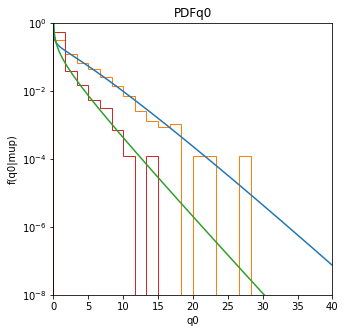

In [74]:
#3b
s = 6
b = 9
tau = 1
mup = 1
q0d = np.linspace(0,40,30001)
# numevents = 5000000
numevents = 5000

# choose n and m such that mu hat = 1
# calculate q0 values for all n,m, that satisfy
# q

y = np.vectorize(PDFq0)(s,b,tau,mup,q0d)

plt.figure(figsize=(5,5))
axes_internal = plt.gca()
logscale: axes_internal.set_yscale('log')
axes_internal.set_ylim(10e-9,1)
axes_internal.set_xlim(0,40)
axes_internal.set_xlabel('q0')
axes_internal.set_ylabel('f(q0|mup)')
plt.title('PDFq0')
plt.plot(q0d,y)

q0s = []
nm = generate_nm(En(s,b,mup),Em(b,tau),numevents)
for evindex in range(numevents):
    q0val = q0(nm[0][evindex],nm[1][evindex],s,b,tau)
    q0s.append(q0val)
plt.hist(q0s,bins=24,range=(-0.001,40),density=True,histtype='step')

# numevents = 10000000
numevents = 5000

mup = 0
y = np.vectorize(PDFq0)(s,b,tau,mup,q0d)
plt.plot(q0d,y)

q0s = []
nm = generate_nm(En(s,b,mup),Em(b,tau),numevents)
for evindex in range(numevents):
    q0val = q0(nm[0][evindex],nm[1][evindex],s,b,tau)
    q0s.append(q0val)
plt.hist(q0s,bins=24,range=(-0.001,40),density=True,histtype='step')


plt.show()

In [ ]:
#4a

s = 10
tau = 1
mup = 1
numevents = 5000000 #Note: 5000000 = 5*10**6 events is not enough, still got 0 events with q0 >=16 for b = 1, 1.58.
# Need more events, in order to do that, I'll likely need to work on the CERN computers.
# To do that, I need to figure out how to get a python script to output and save an image. See vlad's work!




b = []
for a in list(range(0,10)):
    b.append(math.pow(10,0.2*a))
print(b)

zvals = []
for bval in b:
    print(bval)
    q0values = []
    numq0 = 0
    nm = generate_nm(En(s,bval,0),Em(bval,tau),numevents)
    for evindex in range(numevents):
        q0val = q0(nm[0][evindex],nm[1][evindex],s,bval,tau)
        q0values.append(q0val)
#         if q0val != 0:
#             q0s.append(q0val)
        if q0val >= 16:
            numq0 += 1
#     print(numq0)
#     print(p(numq0,numevents))
    print(numq0)
    zvals.append(Z0(numq0/numevents))
print(zvals)
plt.show


plt.figure(figsize=(5,5))
axes_internal = plt.gca()
logscale: axes_internal.set_xscale('log')
axes_internal.set_ylim(1,6)
axes_internal.set_xlim(0.5,10**2)
axes_internal.set_xlabel('b')
axes_internal.set_ylabel('Z0')
plt.title('Z0 vs b')
plt.plot(b,zvals,'ko')
plt.plot([0,100],[4,4])
plt.show

In [ ]:
#4b
tau = 1
mup = 1
# numevents = 5000000
numevents = 50000

s = [1,2,5,10,20]

s = [1,2,5,10,20]

b = np.linspace(0,100,40001)


q0vals = []
for sval in s:
    svals = []
    for bval in b:
        svals.append(np.vectorize(q0)(En(sval,bval,1),Em(bval,tau),s,bval,tau))
    q0vals.append(svals)

plt.figure(figsize=(5,5))
axes_internal = plt.gca()
logscale: axes_internal.set_xscale('log')
logscale: axes_internal.set_yscale('log')
axes_internal.set_ylim(10**(-3),10**2)
axes_internal.set_xlim(0.5,10**2)
axes_internal.set_xlabel('b')
axes_internal.set_ylabel('q0')
plt.title('med q0 vs b')
for i in range(len(s)):
    plt.plot(b,q0vals[i],'b')





b = []
for a in list(range(0,10)):
    b.append(math.pow(10,0.2*a))
print(b)


# choose n and m such that mu hat = 1
# calculate q0 values for all n,m, that satisfy
# q

medianq0list = []
for sval in s:
    medianq0 = []
    for bval in b:
        q0values = []
        nm = generate_nm(En(sval,bval,mup),Em(bval,tau),numevents)
        for evindex in range(numevents):
            q0val = q0(nm[0][evindex],nm[1][evindex],sval,bval,tau)
            q0values.append(q0val)
        medianq0.append(median(q0values))
#     print(medianq0)
    medianq0list.append(medianq0)

for i in range(len(s)):
    plt.plot(b,medianq0list[i],'ro')
plt.show

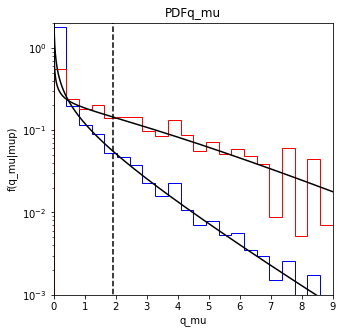

In [88]:
#5a

mu=1

s = 6
b = 9
tau = 1
mup = 1
qvals = np.linspace(0.0000001,9,30001)
# numevents = 50000000
numevents = 1000000
# numevents = 250000
# numevents = 5000



# choose n and m such that mu hat = 1
# calculate q0 values for all n,m, that satisfy
# q



plt.figure(figsize=(5,5))
axes_internal = plt.gca()
logscale: axes_internal.set_yscale('log')
axes_internal.set_ylim(10e-4,2)
axes_internal.set_xlim(0,9)
axes_internal.set_xlabel('q_mu')
axes_internal.set_ylabel('f(q_mu|mup)')
plt.title('PDFq_mu')

y = np.vectorize(PDFq_mu2)(s,b,tau,mu,mup,qvals)
plt.plot(qvals,y,color='black')



# y = np.vectorize(PDFq_mu)(s,b,tau,mu,mup,qvals)
# plt.plot(qvals,y)

q_mus = []
nm = generate_nm(En(s,b,mup),Em(b,tau),numevents)
for evindex in range(numevents):
    q_muval = q_mu(nm[0][evindex],nm[1][evindex],s,b,tau,mu,mup)
    q_mus.append(q_muval)
plt.hist(q_mus,bins=22,range=(0,9),density=True,histtype='step',color='blue')

# numevents = 10000000
numevents = 5000000
# numevents = 1000000
# numevents = 250000
# numevents = 5000

mup = 0
# y = np.vectorize(PDFq_mu)(s,b,tau,mu,mup,qvals)
# plt.plot(qvals,y)

y = np.vectorize(PDFq_mu2)(s,b,tau,mu,mup,qvals)
plt.plot(qvals,y,color='black')


q_mus = []
nm = generate_nm(En(s,b,mup),Em(b,tau),numevents)
for evindex in range(numevents):
    q_muval = q_mu(nm[0][evindex],nm[1][evindex],s,b,tau,mu,mup)
    q_mus.append(q_muval)
plt.hist(q_mus,bins=22,range=(0,9),density=True,histtype='step',color='red')

plt.vlines(q_mu(En(s,b,mup),Em(b,tau),s,b,tau,1,0),0,2,linestyles='dashed')

plt.show()




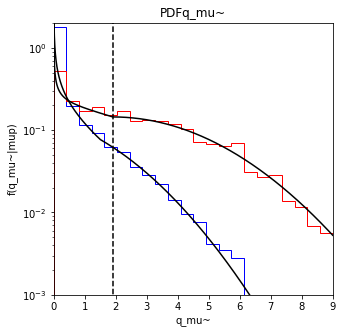

In [87]:
#5b
mu=1

s = 6
b = 9
tau = 1
mup = 1
qvals = np.linspace(0.0000001,9,30001)
# numevents = 50000000
# numevents = 10000000
numevents = 1000000
# numevents = 250000
# numevents = 5000

# choose n and m such that mu hat = 1
# calculate q0 values for all n,m, that satisfy
# q

y = np.vectorize(PDFq_mubar)(s,b,tau,mu,mup,qvals)

plt.figure(figsize=(5,5))
axes_internal = plt.gca()
logscale: axes_internal.set_yscale('log')
axes_internal.set_ylim(10e-4,2)
axes_internal.set_xlim(0,9)
axes_internal.set_xlabel('q_mu~')
axes_internal.set_ylabel('f(q_mu~|mup)')
plt.title('PDFq_mu~')
plt.plot(qvals,y,color='black')

q_mubars = []
nm = generate_nm(En(s,b,mup),Em(b,tau),numevents)
for evindex in range(numevents):
    q_mubarval = q_mubar(nm[0][evindex],nm[1][evindex],s,b,tau,mu,mup)
    q_mubars.append(q_mubarval)
plt.hist(q_mubars,bins=22,range=(0,9),density=True,histtype='step',color='blue')

# numevents = 10000000
numevents = 1000000
# numevents = 250000
# numevents = 5000

mup = 0
y = np.vectorize(PDFq_mubar)(s,b,tau,mu,mup,qvals)
plt.plot(qvals,y,color='black')

q_mubars = []
nm = generate_nm(En(s,b,mup),Em(b,tau),numevents)
for evindex in range(numevents):
    q_mubarval = q_mubar(nm[0][evindex],nm[1][evindex],s,b,tau,mu,mup)
    q_mubars.append(q_mubarval)
plt.hist(q_mubars,bins=22,range=(0,9),density=True,histtype='step',color='red')

plt.vlines(q_mubar(En(s,b,mup),Em(b,tau),s,b,tau,1,0),0,2,linestyles='dashed',color='black')

plt.show()